In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import gc 
import sys
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 

from tqdm import tqdm
from collections import defaultdict
from scipy.spatial import distance
from multiprocessing import cpu_count

from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [48]:
pd.options.display.max_columns = None

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [5]:
var_cols = [f'var_{i}' for i in range(0, 200)]

In [6]:
norm = StandardScaler()
train[var_cols] = norm.fit_transform(train[var_cols])
test[var_cols] = norm.transform(test[var_cols])

In [7]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,...,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05
mean,0.100490,6.984095e-16,-3.493761e-17,-6.816742e-16,-6.580014e-17,-6.352482e-16,1.478817e-17,-9.260245e-17,6.768006e-16,-3.457373e-18,...,-1.794120e-18,2.345457e-16,1.215494e-16,1.252543e-16,-7.931561e-16,5.891176e-17,4.307943e-17,-7.464218e-16,1.394063e-16,3.308326e-17
std,0.300653,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,0.000000,-3.378739e+00,-3.312510e+00,-3.255758e+00,-3.345903e+00,-3.698703e+00,-3.496937e+00,-3.532923e+00,-3.275579e+00,-3.237586e+00,...,-3.800018e+00,-3.350719e+00,-3.884107e+00,-3.786347e+00,-2.966165e+00,-3.581239e+00,-3.027477e+00,-3.198224e+00,-3.178883e+00,-3.403554e+00
25%,0.000000,-7.322476e-01,-7.684882e-01,-7.545633e-01,-7.548787e-01,-7.363223e-01,-7.802162e-01,-7.399549e-01,-7.612636e-01,-7.807544e-01,...,-7.222214e-01,-7.544853e-01,-7.021442e-01,-6.881662e-01,-7.540249e-01,-7.196264e-01,-7.792415e-01,-7.110907e-01,-6.778686e-01,-7.551204e-01
50%,0.000000,-5.104015e-02,4.832475e-03,-5.119182e-02,1.393366e-02,1.843135e-02,2.952565e-02,-2.751966e-02,-2.605270e-02,3.286843e-02,...,-6.763242e-03,-2.998690e-02,-1.795060e-02,1.617635e-02,-1.142980e-02,-2.141614e-02,1.935421e-02,-2.165493e-02,2.103323e-02,4.857132e-02
75%,0.000000,6.836369e-01,7.373387e-01,6.821601e-01,7.475948e-01,7.287035e-01,7.617868e-01,6.854925e-01,7.480983e-01,7.962906e-01,...,6.955751e-01,6.860521e-01,6.910499e-01,7.199428e-01,7.663868e-01,6.798025e-01,7.798153e-01,7.434083e-01,7.286782e-01,7.820795e-01
max,1.000000,3.169391e+00,2.964030e+00,3.270797e+00,3.128139e+00,3.445820e+00,2.838130e+00,3.506501e+00,3.260893e+00,2.960770e+00,...,3.334816e+00,3.068899e+00,4.379381e+00,3.744977e+00,3.168908e+00,3.088768e+00,2.936766e+00,3.355213e+00,3.390432e+00,3.049173e+00


In [8]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,-0.006966,0.000834,-0.002931,-0.004069,-0.001192,0.001877,0.007172,-0.004888,-0.002109,0.001758,...,-0.009797,0.006569,-0.001281,-0.002444,0.001015,0.005899,-0.002280,0.004634,-0.000510,0.007683
std,0.998905,0.997648,0.997350,1.004605,0.995879,1.000769,0.997786,1.001877,1.000225,0.997408,...,0.998098,1.000637,1.001046,1.000896,1.001754,1.000216,0.998531,0.999220,0.999262,0.996225
min,-3.451008,-3.312510,-3.165599,-3.337191,-3.446354,-2.887062,-3.683972,-3.169086,-3.072701,-2.691301,...,-3.800018,-3.256549,-3.563765,-3.693587,-2.746590,-3.337006,-2.978818,-2.971451,-3.084328,-3.461516
25%,-0.735825,-0.758636,-0.749593,-0.766416,-0.731455,-0.780350,-0.734301,-0.764160,-0.776584,-0.763875,...,-0.730155,-0.751475,-0.706744,-0.687415,-0.752438,-0.712630,-0.779549,-0.703197,-0.672032,-0.747027
50%,-0.054642,0.009166,-0.058500,0.012637,0.013195,0.029405,-0.020019,-0.036029,0.026357,0.052437,...,-0.015799,-0.019650,-0.023835,0.024230,-0.005162,-0.013930,0.018383,-0.016664,0.024139,0.057539
75%,0.677519,0.733579,0.673953,0.749308,0.723944,0.764047,0.688724,0.745655,0.793928,0.823914,...,0.680284,0.692196,0.695447,0.712027,0.764856,0.685609,0.773045,0.746229,0.722193,0.791526
max,3.830039,2.719168,3.028871,3.105480,3.055035,2.838397,3.338950,3.436723,2.814999,2.782330,...,3.755460,3.068899,4.110581,3.582353,3.174969,3.279411,2.496604,3.654034,3.542976,2.992333


In [25]:
cluster = KMeans(n_clusters=2, n_jobs=-1)
train['kmeans_2'] = cluster.fit_predict(train[var_cols])
test['kmeans_2'] = cluster.predict(test[var_cols])

In [40]:
train['plus'] = (train.loc[:, var_cols] >= 0).sum(axis=1)
train['minus'] = 200 - train['plus']

In [41]:
test['plus'] = (test.loc[:, var_cols] >= 0).sum(axis=1)
test['minus'] = 200 - test['plus']

In [45]:
train.query('kmeans_2 == 0').describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_193,var_194,var_195,var_196,var_197,var_198,var_199,kmeans_2,plus,minus
count,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,...,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,91934.000000,91934.0,91934.000000,91934.000000
mean,0.194814,0.096119,0.080416,0.098027,0.010949,0.009126,0.026189,0.117243,-0.009331,0.021803,...,-0.030084,-0.056213,0.057424,0.060796,-0.030382,-0.097809,0.077870,0.0,100.015120,99.984880
std,0.396059,1.011563,1.002821,1.013559,1.000313,1.003864,1.002787,1.008697,0.999660,1.000012,...,1.001872,0.999806,1.005012,1.000415,1.003214,1.011718,0.991546,0.0,7.081978,7.081978
min,0.000000,-3.364134,-3.064018,-3.067223,-3.345903,-3.698703,-3.496937,-3.361333,-3.158642,-3.237586,...,-3.786347,-2.966165,-3.581239,-3.027477,-3.103826,-3.092731,-3.403554,0.0,70.000000,71.000000
25%,0.000000,-0.644362,-0.680501,-0.666932,-0.742485,-0.730577,-0.751376,-0.630793,-0.770201,-0.755422,...,-0.716755,-0.805880,-0.665407,-0.706611,-0.735396,-0.776999,-0.662356,0.0,95.000000,95.000000
50%,0.000000,0.056919,0.097005,0.063296,0.025777,0.025640,0.064028,0.109279,-0.037814,0.057609,...,-0.015149,-0.076355,0.036896,0.099327,-0.053718,-0.085246,0.146243,0.0,100.000000,100.000000
75%,0.000000,0.778471,0.817079,0.777810,0.754642,0.741996,0.784309,0.808126,0.735569,0.819486,...,0.688624,0.700609,0.737100,0.835913,0.708985,0.633508,0.851379,0.0,105.000000,105.000000
max,1.000000,3.169391,2.964030,3.270797,3.128139,3.084854,2.822424,3.506501,3.233363,2.796936,...,3.555975,3.168908,3.088768,2.819905,3.355213,3.375652,2.956560,0.0,129.000000,130.000000


In [46]:
train.query('kmeans_2 == 1').describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_193,var_194,var_195,var_196,var_197,var_198,var_199,kmeans_2,plus,minus
count,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,...,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,108066.000000,108066.0,108066.000000,108066.000000
mean,0.020247,-0.081770,-0.068412,-0.083393,-0.009314,-0.007763,-0.022279,-0.099741,0.007938,-0.018548,...,0.025593,0.047822,-0.048851,-0.051721,0.025847,0.083208,-0.066246,1.0,99.816344,100.183656
std,0.140844,0.982693,0.992487,0.980644,0.999649,0.996644,0.997091,0.981588,1.000230,0.999624,...,0.997700,0.997684,0.993115,0.996741,0.996538,0.982295,1.002394,0.0,7.067751,7.067751
min,0.000000,-3.378739,-3.312510,-3.255758,-3.318300,-3.573637,-3.257723,-3.532923,-3.275579,-3.083234,...,-3.417661,-2.726623,-3.506871,-2.992789,-3.198224,-3.178883,-3.403554,1.0,70.000000,69.000000
25%,0.000000,-0.799196,-0.838148,-0.823887,-0.764642,-0.741852,-0.801988,-0.820384,-0.754593,-0.801084,...,-0.664394,-0.706914,-0.764401,-0.835357,-0.690448,-0.585871,-0.827836,1.0,95.000000,95.000000
50%,0.000000,-0.138078,-0.075278,-0.144304,0.003852,0.013010,-0.000564,-0.140835,-0.015433,0.011669,...,0.040562,0.044118,-0.071228,-0.045869,0.004820,0.110291,-0.033935,1.0,100.000000,100.000000
75%,0.000000,0.595801,0.665852,0.607829,0.741282,0.717290,0.741754,0.578062,0.757307,0.776396,...,0.745538,0.819478,0.630760,0.728049,0.772704,0.800408,0.719802,1.0,105.000000,105.000000
max,1.000000,2.921006,2.953857,2.999071,3.024876,3.445820,2.838130,3.400224,3.260893,2.960770,...,3.744977,3.027607,3.076735,2.936766,3.304216,3.390432,3.049173,1.0,131.000000,130.000000


In [56]:
train.sort_values(by=['minus', 'target', 'var_0'])

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,kmeans_2,plus,minus
18406,train_18406,0,-0.654272,1.205403,0.751947,-0.339512,0.807671,2.194325,-0.411201,0.269611,0.491816,1.201768,0.426714,1.109821,2.049483,-0.699066,0.539344,2.068624,1.283537,0.435797,0.374214,-0.078216,-0.824115,-0.931195,-0.613961,-1.440788,-1.023420,1.405447,0.150929,-0.143132,1.260358,-0.149764,1.433570,0.835301,0.146527,0.962668,1.936531,-0.397293,0.298423,0.247542,0.219045,1.024432,0.694473,-0.139702,0.106387,-0.075433,1.371020,-2.103557,0.995353,-0.678703,-0.515588,0.237941,1.302450,0.879435,0.124604,-0.245922,0.831376,-1.086993,0.383495,-1.839710,-0.843311,-0.381757,0.891294,1.226770,0.433183,-0.713433,-0.437835,1.321915,-1.081843,0.145562,-0.054751,0.536848,-2.744018,-2.343332,-1.274739,1.035229,0.922374,0.065970,0.388372,0.876122,-0.837040,0.453278,0.043508,0.934037,-0.311777,0.167355,1.191721,-1.060993,-0.605765,1.440291,0.480112,1.640140,0.209085,-0.838189,1.202373,-0.522398,2.452642,-1.583832,0.536852,0.882253,0.689389,-0.720951,-0.014462,0.464956,-1.991828,0.496746,0.304522,0.145094,-1.475258,1.411039,1.134279,1.417398,0.369284,-0.403365,0.470697,0.334455,-0.174845,1.248237,1.470240,1.256981,-0.533076,1.894850,0.482817,-0.698368,0.660044,0.256265,1.304312,1.221112,0.328681,-1.592550,0.766963,0.863782,-0.184873,1.456184,0.412105,1.047729,0.498280,0.336843,1.054332,-1.469294,-0.383939,0.979534,1.093652,1.218563,1.075193,0.955158,0.657226,-0.370204,-0.025399,-1.922889,-0.505169,0.255815,-0.028071,-0.485396,0.076231,1.014300,-0.253132,1.664342,-0.838070,-0.432753,1.072240,-0.096190,0.748964,-1.061278,0.340026,-1.381074,0.231561,0.740331,-1.092110,1.168486,1.105505,0.322631,0.233481,-1.692438,0.027093,1.412628,0.467774,1.328829,0.632171,0.296615,0.901032,-1.548132,0.419401,1.755123,-1.741749,1.326621,-1.042489,-0.660854,0.769441,0.690718,0.755775,0.826376,1.499275,0.379653,1.030399,0.842913,-1.671013,0.138025,-0.676420,0.307981,1.584616,1.038604,1,131,69
166265,train_166265,0,-1.181962,0.808517,0.422020,-0.138515,0.603068,0.713893,-0.524517,0.673436,0.271719,0.219392,-0.290003,0.607630,0.022741,0.655707,0.889315,0.999183,-2.398541,0.269602,0.862118,0.223209,-0.673049,0.130789,-2.815017,-0.659034,1.103691,0.288946,0.413839,1.685168,1.408309,0.301126,0.613927,-1.236430,1.605939,0.497755,-0.039788,0.627488,1.442056,0.659414,-1.163813,0.074283,0.399675,0.545420,0.010264,1.107712,-0.302180,0.157757,0.054016,0.102500,-0.628937,0.823220,0.962422,-0.108560,0.286874,1.090199,0.188156,-0.871002,1.432005,0.733294,1.744900,-0.27635

In [52]:
train.query('target == 0').sort_values(by=['minus', 'target'])

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,kmeans_2,plus,minus
18406,train_18406,0,-0.654272,1.205403,0.751947,-0.339512,0.807671,2.194325,-0.411201,0.269611,0.491816,1.201768,0.426714,1.109821,2.049483,-0.699066,0.539344,2.068624,1.283537,0.435797,0.374214,-0.078216,-0.824115,-0.931195,-0.613961,-1.440788,-1.023420,1.405447,0.150929,-0.143132,1.260358,-0.149764,1.433570,0.835301,0.146527,0.962668,1.936531,-0.397293,0.298423,0.247542,0.219045,1.024432,0.694473,-0.139702,0.106387,-0.075433,1.371020,-2.103557,0.995353,-0.678703,-0.515588,0.237941,1.302450,0.879435,0.124604,-0.245922,0.831376,-1.086993,0.383495,-1.839710,-0.843311,-0.381757,0.891294,1.226770,0.433183,-0.713433,-0.437835,1.321915,-1.081843,0.145562,-0.054751,0.536848,-2.744018,-2.343332,-1.274739,1.035229,0.922374,0.065970,0.388372,0.876122,-0.837040,0.453278,0.043508,0.934037,-0.311777,0.167355,1.191721,-1.060993,-0.605765,1.440291,0.480112,1.640140,0.209085,-0.838189,1.202373,-0.522398,2.452642,-1.583832,0.536852,0.882253,0.689389,-0.720951,-0.014462,0.464956,-1.991828,0.496746,0.304522,0.145094,-1.475258,1.411039,1.134279,1.417398,0.369284,-0.403365,0.470697,0.334455,-0.174845,1.248237,1.470240,1.256981,-0.533076,1.894850,0.482817,-0.698368,0.660044,0.256265,1.304312,1.221112,0.328681,-1.592550,0.766963,0.863782,-0.184873,1.456184,0.412105,1.047729,0.498280,0.336843,1.054332,-1.469294,-0.383939,0.979534,1.093652,1.218563,1.075193,0.955158,0.657226,-0.370204,-0.025399,-1.922889,-0.505169,0.255815,-0.028071,-0.485396,0.076231,1.014300,-0.253132,1.664342,-0.838070,-0.432753,1.072240,-0.096190,0.748964,-1.061278,0.340026,-1.381074,0.231561,0.740331,-1.092110,1.168486,1.105505,0.322631,0.233481,-1.692438,0.027093,1.412628,0.467774,1.328829,0.632171,0.296615,0.901032,-1.548132,0.419401,1.755123,-1.741749,1.326621,-1.042489,-0.660854,0.769441,0.690718,0.755775,0.826376,1.499275,0.379653,1.030399,0.842913,-1.671013,0.138025,-0.676420,0.307981,1.584616,1.038604,1,131,69
166265,train_166265,0,-1.181962,0.808517,0.422020,-0.138515,0.603068,0.713893,-0.524517,0.673436,0.271719,0.219392,-0.290003,0.607630,0.022741,0.655707,0.889315,0.999183,-2.398541,0.269602,0.862118,0.223209,-0.673049,0.130789,-2.815017,-0.659034,1.103691,0.288946,0.413839,1.685168,1.408309,0.301126,0.613927,-1.236430,1.605939,0.497755,-0.039788,0.627488,1.442056,0.659414,-1.163813,0.074283,0.399675,0.545420,0.010264,1.107712,-0.302180,0.157757,0.054016,0.102500,-0.628937,0.823220,0.962422,-0.108560,0.286874,1.090199,0.188156,-0.871002,1.432005,0.733294,1.744900,-0.27635

In [53]:
train.query('target == 1').sort_values(by=['minus', 'target'])

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,kmeans_2,plus,minus
127188,train_127188,1,-0.587727,0.942417,1.023485,0.096594,1.271277,1.576387,0.568715,0.483680,-0.390161,-0.612628,1.056225,0.752934,0.416830,1.297734,-0.575472,1.724450,0.706235,1.166603,1.311072,-0.269721,0.809005,-1.998584,0.834870,-1.085687,1.012354,-1.713963,2.501392,0.274795,0.807185,1.637245,0.357310,-0.999797,0.400795,0.231139,0.722011,-0.782443,0.580381,-0.139483,-1.116067,-1.664102,-0.948649,0.483581,-1.340906,1.645182,0.377874,1.951420,-0.716653,1.185164,-1.924194,1.634448,0.930327,0.179631,0.455863,-0.570864,-0.251125,0.428053,-0.971075,0.981714,-0.951138,-1.415337,-0.216399,1.282892,1.089475,1.148228,-1.543128,-0.832300,1.479772,1.996535,0.988909,-0.679267,-2.452620,0.419370,-1.803829,1.330329,0.925152,0.661712,0.902548,0.084093,-1.028986,-0.822684,0.815394,0.267823,0.529703,-0.844178,1.969886,-0.460997,-0.066875,1.122056,-0.142456,0.593811,-0.088001,1.266760,-1.588460,0.944824,1.180936,1.097759,-0.843720,-0.859559,0.618982,0.986175,2.253963,0.723777,-0.167279,0.468641,0.676862,0.827930,1.010422,-0.242832,1.373918,0.756460,-0.406393,-0.688657,1.383235,-0.612447,0.691103,0.610823,-1.352449,1.266795,-0.387518,0.857455,1.018582,-1.393475,-0.300376,1.382640,0.447988,0.291528,-1.253297,1.425352,0.191027,0.676931,1.120106,0.990680,-1.408308,1.637714,0.158763,-0.914451,1.316733,2.021502,0.445832,1.035972,-0.857877,-1.766180,-0.193518,0.247420,-0.417610,0.838791,0.729262,-0.479170,1.016980,0.922173,1.660462,-0.202993,-0.675259,-2.141948,1.804927,-0.459012,0.979992,0.872805,0.568027,2.042571,0.260463,0.157419,0.345027,-1.444091,-1.347271,0.814492,-0.235702,0.291761,0.579842,0.235742,0.397586,0.455890,-0.468103,1.358728,1.207417,-0.656261,-0.659711,0.111517,-0.600171,0.015776,0.588886,-0.574635,1.096211,-0.944664,0.921988,-0.300189,0.033240,-1.855408,-0.240120,2.195871,0.985055,0.997925,-1.191231,-1.018801,0.098916,0.115917,1.098217,0.845185,-0.120800,-0.478700,0,125,75
4969,train_4969,1,1.445962,-0.991097,0.615061,0.165159,-2.856696,-1.716820,0.061794,-1.120063,0.028578,0.180285,1.005832,-0.500416,-0.630215,1.518813,-0.691536,-0.886123,0.998288,-1.126102,-0.593683,-0.618616,-1.407175,-0.564834,1.286704,2.255035,1.281678,1.313339,0.684971,1.155474,0.039344,-1.562605,1.261621,-0.488705,-0.371283,0.641613,-0.372129,-1.029588,-1.224220,-0.636789,-1.670533,-0.873434,1.342069,0.110346,0.585848,0.849636,-0.408024,0.861873,0.554872,-0.137428,-0.833851,0.020686,0.245355,1.257790,0.997051,2.143353,0.402139,-0.103242,-1.337018,0.610153,1

In [55]:
test.sort_values(by=['minus'])

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,kmeans_2,plus,minus
135912,test_135912,-0.042932,-0.369596,0.714157,-1.936623,0.023637,-1.187942,-0.358235,-0.740667,1.581887,-0.494901,-0.093576,0.056714,0.543633,1.001238,-0.856490,-1.841163,-0.539593,-1.477844,0.577644,-0.470429,-0.687905,-1.761301,1.547031,1.336441,-1.606783,-0.034658,0.123203,0.577936,-1.532848,-0.402293,-2.153481,0.609363,0.222343,0.720714,1.908836,0.257571,1.542922,-0.073298,0.071647,-1.093398,0.037866,0.227151,-0.056260,1.831875,-0.269316,-1.225761,0.257756,0.794770,-0.385918,0.085925,1.368229,0.725990,0.661338,0.648356,0.621196,2.005331,1.404775,0.452045,-0.372296,1.756882,-0.461521,0.649987,0.218894,0.019121,0.215057,-0.594507,0.405187,1.058326,1.030655,1.089289,0.193779,0.832201,0.009746,-0.407859,0.916698,1.308599,1.970153,0.489408,1.145067,-0.100788,0.277805,0.221380,1.141385,0.198438,0.490533,0.083939,0.070640,0.586595,0.440095,0.869415,0.049841,0.538249,0.744778,0.415321,0.266840,0.315145,2.029314,0.436205,-1.747070,0.771845,0.100910,0.156544,-0.825936,-0.513961,-1.051570,-0.551065,0.377564,-1.806180,1.202664,1.240270,0.923211,-1.355507,0.236780,0.387673,0.370622,0.266752,0.292888,0.316798,0.680448,-1.478930,0.671069,-1.049976,0.126907,-0.371568,2.338215,1.672229,1.156201,0.095419,-0.209525,0.764107,1.423640,-0.671242,-0.387149,-0.002850,-0.173569,1.659549,0.685596,1.886684,-0.243729,-0.365124,0.275159,0.649710,1.359033,0.996321,0.412772,-1.633261,-0.028933,-2.396134,-0.557380,-0.184970,0.966348,2.001142,-1.593516,0.036192,0.014238,-0.627659,0.612925,1.005115,1.308456,0.726920,-1.410061,0.548356,-1.828318,0.235979,1.367116,0.525270,0.768130,0.437004,0.596197,-0.056866,0.267518,-0.317595,0.242146,1.313074,-0.761094,-1.358712,0.009434,0.584607,0.108215,-1.898549,0.705266,0.659092,0.805083,1.928755,-0.881536,0.029959,0.249589,-0.505876,-0.913902,2.133188,0.575332,1.332828,-0.165473,0.443416,-0.121105,0.095908,0.018089,0.055383,2.018401,0.275440,1,133,67
169375,test_169375,1.213925,0.937973,-1.563146,1.141954,0.736389,1.141490,-1.764528,2.165829,-1.995713,1.387345,1.077295,0.651029,1.466505,-0.647854,0.985939,0.306949,0.580835,0.599996,1.205078,1.379027,-0.853062,1.696181,1.072936,-0.293115,0.817979,-0.862228,0.403657,-0.809795,-0.807005,1.185552,0.273445,0.596862,-1.069553,1.066478,-0.049758,1.897966,0.692978,0.007246,0.697299,-0.044277,0.214743,-1.067107,-0.296206,0.664880,0.252075,-1.233698,1.218251,1.951877,0.100620,0.938715,-0.106238,0.153175,0.287897,0.545316,2.421577,0.777681,1.446411,-0.332837,0.174965,1.670078,-0.185184,

In [82]:
train['unique'] = train[var_cols].apply(lambda x: len(x.unique()), axis=1)

In [87]:
pca = PCA(n_components=2)
res = pca.fit_transform(train[var_cols])
train['pca_2_1'] = res[:, 0]
train['pca_2_2'] = res[:, 1]

In [117]:
train['pca_2_1_2'] = train['pca_2_1'] ** 2
train['pca_2_2_2'] = train['pca_2_2'] ** 2

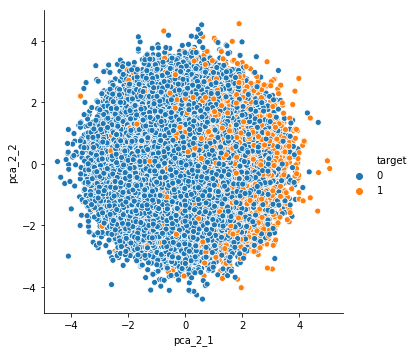

In [88]:
sns.relplot(x='pca_2_1', y='pca_2_2', hue='target', data=train)
plt.show()

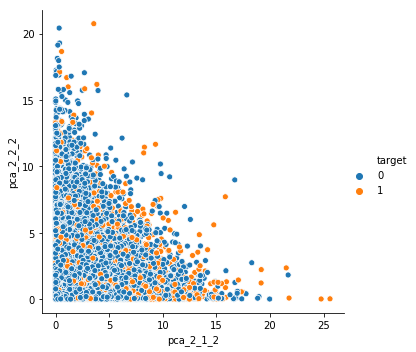

In [118]:
sns.relplot(x='pca_2_1_2', y='pca_2_2_2', hue='target', data=train)
plt.show()

In [94]:
train_0 = train.query('kmeans_2 == 0')

pca = PCA(n_components=2)
res = pca.fit_transform(train_0[var_cols])
train_0['pca_2_1'] = res[:, 0]
train_0['pca_2_2'] = res[:, 1]

In [105]:
train_0['pca_2_1_2'] = train_0['pca_2_1'] ** 2
train_0['pca_2_2_2'] = train_0['pca_2_2'] ** 2

In [115]:
train_0['log_pca_2_1'] = np.log(train_0['pca_2_1']) ** 2
train_0['log_pca_2_2'] = np.log(train_0['pca_2_2']) ** 2

In [121]:
train_0['pca_2_1_add_pca_2_2'] = train_0['pca_2_1'] + train_0['pca_2_2']
train_0['pca_2_1_mul_pca_2_2'] = train_0['pca_2_1'] * train_0['pca_2_2']
train_0['pca_2_1_div_pca_2_2'] = train_0['pca_2_1'] / train_0['pca_2_2']
train_0['pca_2_1_sub_pca_2_2'] = np.abs(train_0['pca_2_1'] - train_0['pca_2_2'])

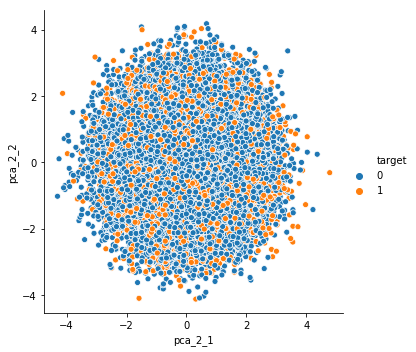

In [106]:
sns.relplot(x='pca_2_1', y='pca_2_2', hue='target', data=train_0)
plt.show()

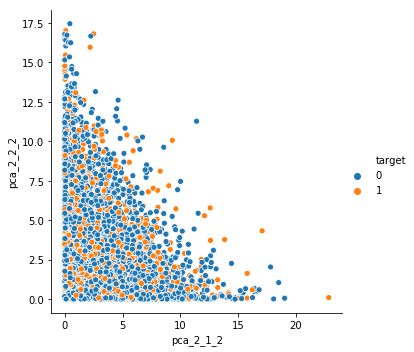

In [113]:
sns.relplot(x='pca_2_1_2', y='pca_2_2_2', hue='target', data=train_0)
plt.show()

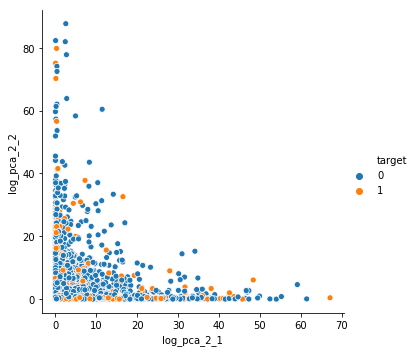

In [116]:
sns.relplot(x='log_pca_2_1', y='log_pca_2_2', hue='target', data=train_0)
plt.show()

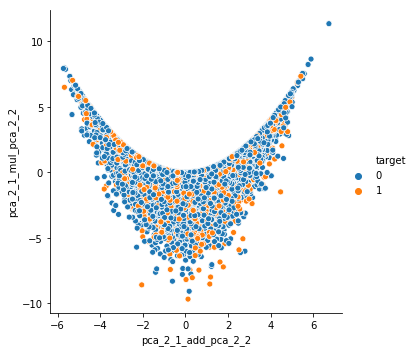

In [122]:
sns.relplot(x='pca_2_1_add_pca_2_2', y='pca_2_1_mul_pca_2_2', hue='target', data=train_0)
plt.show()

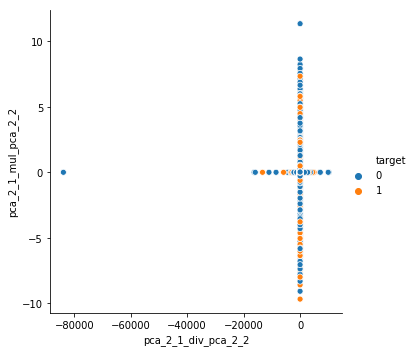

In [123]:
sns.relplot(x='pca_2_1_div_pca_2_2', y='pca_2_1_mul_pca_2_2', hue='target', data=train_0)
plt.show()

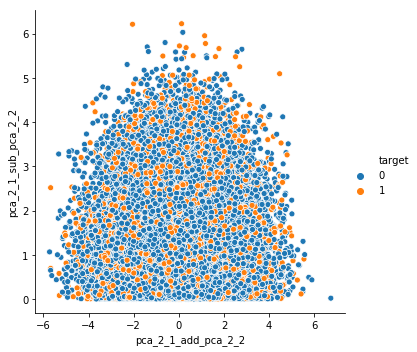

In [125]:
sns.relplot(x='pca_2_1_add_pca_2_2', y='pca_2_1_sub_pca_2_2', hue='target', data=train_0)
plt.show()

In [96]:
train_1 = train.query('kmeans_2 == 1')

pca = PCA(n_components=2)
res = pca.fit_transform(train_1[var_cols])
train_1['pca_2_1'] = res[:, 0]
train_1['pca_2_2'] = res[:, 1]

In [100]:
train_1['pca_2_1_2'] = train_1['pca_2_1'] ** 2
train_1['pca_2_2_2'] = train_1['pca_2_2'] ** 2

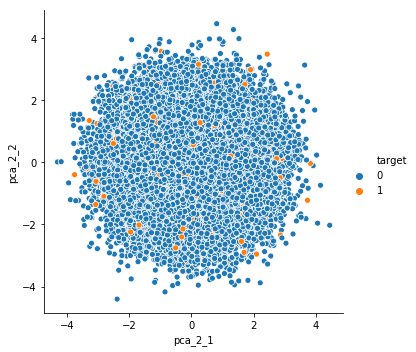

In [97]:
sns.relplot(x='pca_2_1', y='pca_2_2', hue='target', data=train_1)
plt.show()

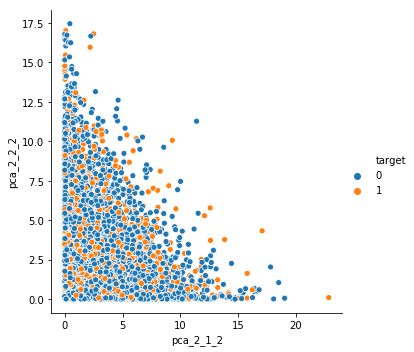

In [102]:
sns.relplot(x='pca_2_1_2', y='pca_2_2_2', hue='target', data=train_0)
plt.show()

In [146]:
cluster = KMeans(n_clusters=10, n_jobs=-1)
train_0['kmeans_2_2'] = cluster.fit_predict(train_0[[f'var_{i}' for i in range(0, 200, 2)]])

sns.countplot(x='kmeans_2_2', hue='target', data=train_0)
plt.show()

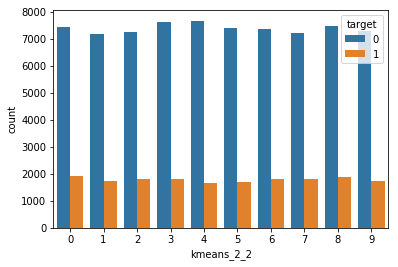

In [147]:
sns.countplot(x='kmeans_2_2', hue='target', data=train_0)
plt.show()

In [133]:
cluster = KMeans(n_clusters=10, n_jobs=-1)
train_1['kmeans_2_2'] = cluster.fit_predict(train_1[var_cols])

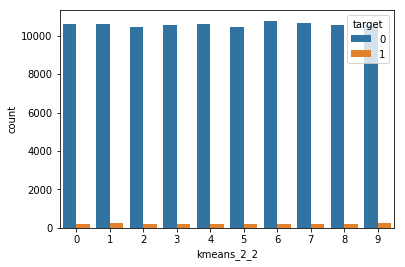

In [134]:
sns.countplot(x='kmeans_2_2', hue='target', data=train_1)
plt.show()

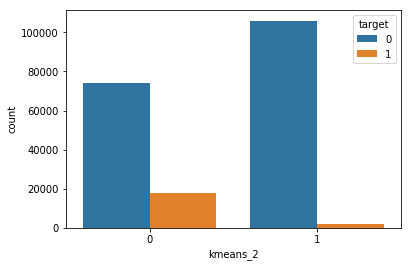

In [150]:
sns.countplot(x='kmeans_2', hue='target', data=train)
plt.show()

In [ ]:
cluster = KMeans(n_clusters=10, n_jobs=-1)
train['kmeans_2_2'] = cluster.fit_predict(train[var_cols])

sns.countplot(x='kmeans_2_2', hue='target', data=train)
plt.show()

In [ ]:
cluster = KMeans(n_clusters=20, n_jobs=-1)
train['kmeans_20'] = cluster.fit_predict(train[var_cols])

sns.countplot(x='kmeans_20', hue='target', data=train)
plt.show()

In [ ]:
cluster = KMeans(n_clusters=30, n_jobs=-1)
train['kmeans_30'] = cluster.fit_predict(train[var_cols])

sns.countplot(x='kmeans_30', hue='target', data=train)
plt.show()

In [ ]:
cluster = KMeans(n_clusters=40, n_jobs=-1)
train['kmeans_40'] = cluster.fit_predict(train[var_cols])

sns.countplot(x='kmeans_40', hue='target', data=train)
plt.show()

In [ ]:
cluster = KMeans(n_clusters=50, n_jobs=-1)
train['kmeans_50'] = cluster.fit_predict(train[var_cols])

sns.countplot(x='kmeans_50', hue='target', data=train)
plt.show()

In [ ]:
cluster = KMeans(n_clusters=100, n_jobs=-1)
train['kmeans_100'] = cluster.fit_predict(train[var_cols])

sns.countplot(x='kmeans_100', hue='target', data=train)
plt.show()

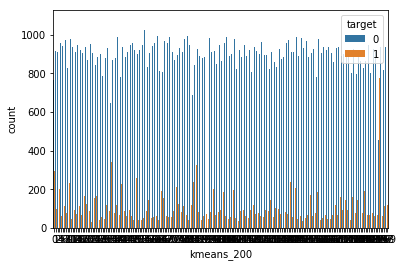

In [156]:
cluster = KMeans(n_clusters=200, n_jobs=-1)
train['kmeans_200'] = cluster.fit_predict(train[var_cols])

sns.countplot(x='kmeans_200', hue='target', data=train)
plt.show()

In [158]:
test['kmeans_200'] = cluster.predict(test[var_cols])

In [157]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=618)

In [ ]:
for i in [2, 10, 20, 30, 40, 50, 100, 200]:
    train[f'te_{i}'] = 0
    test[f'te_{i}'] = 0
    for fold, (train_index, valid_index) in enumerate(skf.split(train, train['target'])):
        train_ = train.iloc[train_index]
        valid_ = train.iloc[valid_index]

        te = train_.groupby(f'kmeans_{i}')['target'].mean()
        train.ix[valid_index, 'te_{i}'] = valid_[f'kmeans_{i}'].map(te)

    te = train_.groupby(f'kmeans_{i}')['target'].mean()
    test[f'te_{i}'] += test['kmeans_{i}'].map(te)

In [164]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,kmeans_2,plus,minus,unique,pca_2_1,pca_2_2,pca_2_1_2,pca_2_2_2,kmeans_2_2,kmeans_20,kmeans_200,te
0,train_0,0,-0.577102,-1.273737,0.451707,-0.833709,0.235571,-0.536430,-0.334926,0.608751,-1.561580,-1.473796,0.460091,1.076623,-0.054077,-1.714773,0.561098,-0.009778,-1.401636,-0.229802,-1.395940,2.285292,-0.468989,-0.126734,-0.606166,-1.039947,1.005683,-0.823003,-0.184673,0.479492,-0.768964,0.360340,0.926437,1.162587,-1.299824,0.489773,-0.447275,1.300500,-0.484245,0.897088,-1.396490,0.789254,0.179582,-0.324223,0.509123,1.533101,0.456291,0.265485,-1.889139,-0.164640,0.116264,-1.445719,0.257933,1.907481,0.368029,-1.091818,-0.223968,0.366666,-1.514722,-1.119228,-0.269821,1.386852,0.953771,1.454518,0.593678,-0.281577,1.551733,2.257770,0.010310,1.424133,-1.112326,-0.346204,-0.235063,-0.387918,1.155818,-1.439925,1.671834,0.252319,-1.057511,1.137827,0.587034,-1.683537,1.055809,-0.383475,0.570662,0.230979,-0.310201,0.794207,0.477536,0.902216,-0.282776,-1.525640,-0.372640,-1.355746,-0.393474,-1.040675,1.388299,0.427522,-0.637653,-0.180540,0.589925,-1.431860,1.750971,-0.020872,0.491726,-0.692321,1.624026,2.104318,0.488124,-0.084272,-0.666520,1.355837,-0.910467,0.413522,0.374729,-1.933508,-0.565450,-0.268672,0.090272,-0.039634,-0.922462,1.013930,-0.702227,-0.923810,-0.058680,-1.024974,-0.018613,-1.525514,0.843723,-0.505249,-0.245997,-0.003412,0.686795,-0.407587,1.270955,-0.654603,1.621549,0.970629,0.624732,1.551190,0.355273,1.027749,1.002196,-1.265512,1.243501,-0.363716,0.055578,0.904803,0.486218,-1.776800,0.191144,1.215988,0.689904,0.161129,0.456650,-0.015640,0.707191,0.646555,-1.082956,-1.493440,-0.039210,0.319925,-0.808962,-1.468275,-1.230618,-1.133356,1.749415,-1.323871,-0.711244,0.442890,1.500647,-0.400904,-1.075697,-1.411980,0.122226,0.642079,-0.231051,-1.347890,-0.974846,0.700359,-0.291946,-0.311275,-1.076447,-0.779321,0.261797,1.251424,1.404031,2.086632,0.900016,-0.810464,0.556997,-0.164257,0.263374,-1.149158,0.817469,-0.411013,0.168705,-1.578117,1.022131,-0.373968,-1.026398,0.214135,1,97,103,200,0.469609,-0.283718,0.220533,0.080496,7,93,176,0.115429
1,train_1,0,0.269959,-0.622138,1.190360,-0.688846,0.790975,1.539900,0.244461,-0.003525,0.858974,0.419300,-0.144987,1.893408,-0.000409,-0.025160,-0.935586,-2.120000,1.757336,-1.473077,-0.948119,2.017368,-1.678317,-1.771135,1.491237,0.668183,-0.954799,0.782756,-1.302434,-0.932390,-0.621140,-1.722433,-0.202250,-1.165592,0.695096,1.063517,-0.118257,-0.599010,0.196242,-0.011334,0.040634,0.741083,-0.530145,-1.250719

In [165]:
y = train['target']

not_use_cols = ['ID_code', 'target']
# use_cols = [f for f in train.columns if f not in not_use_cols]
use_cols = [f'var_{i}' for i in range(0, 200)]
use_cols += ['te']

X = train[use_cols]
X_test = test[use_cols]

In [166]:
oof, predictions, scores, feature_importance_df = cv_lightgbm(X, y, X_test, NFOLDS=6, SEED=618)

fold: 1/6
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.859672	valid_1's auc: 0.85491
[1000]	training's auc: 0.874326	valid_1's auc: 0.868254
[1500]	training's auc: 0.883542	valid_1's auc: 0.876724
[2000]	training's auc: 0.889505	valid_1's auc: 0.882648
[2500]	training's auc: 0.893316	valid_1's auc: 0.885803
[3000]	training's auc: 0.896482	valid_1's auc: 0.888646
[3500]	training's auc: 0.899006	valid_1's auc: 0.891119
[4000]	training's auc: 0.900889	valid_1's auc: 0.892771
[4500]	training's auc: 0.902674	valid_1's auc: 0.894373
[5000]	training's auc: 0.904034	valid_1's auc: 0.895469
[5500]	training's auc: 0.905126	valid_1's auc: 0.89631
[6000]	training's auc: 0.90643	valid_1's auc: 0.897405
[6500]	training's auc: 0.907362	valid_1's auc: 0.897921
[7000]	training's auc: 0.908376	valid_1's auc: 0.89873
[7500]	training's auc: 0.909117	valid_1's auc: 0.89904
[8000]	training's auc: 0.909813	valid_1's auc: 0.899377
[8500]	training's auc: 0.910366	valid

In [167]:
cv_score = roc_auc_score(y, oof)**0.5
print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
print('CV Score: {:<8.5f}'.format(cv_score))

Train Scores: mean 0.91079, max 0.91207, min 0.90933, std 0.00091
Valid Scores: mean 0.89934, max 0.90142, min 0.89746, std 0.00148
CV Score: 0.94830 


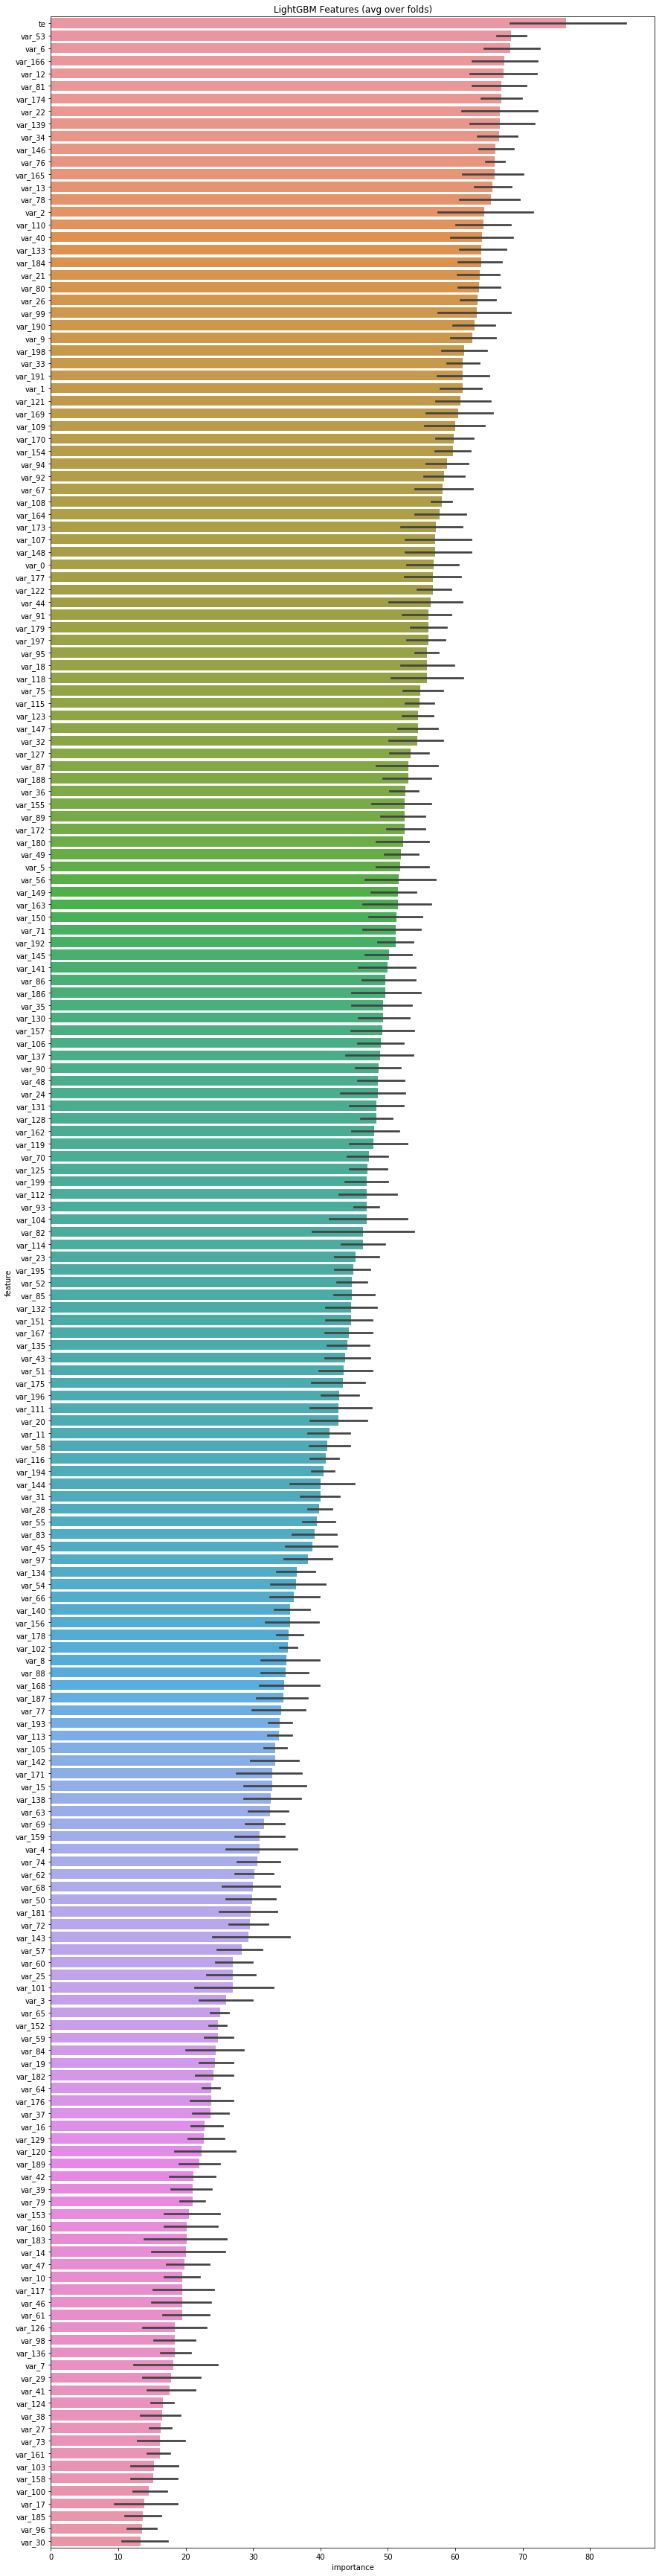

In [168]:
feature_importance_df['importance'] = feature_importance_df['importance'].astype('int')
ordered_feature = feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 48))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
sns.barplot(x='importance', y='feature', data=feature_importance_df, order=ordered_feature)
plt.show()

In [21]:
submission = pd.read_csv(os.path.join('..', 'data', 'sample_submission.csv'))
submission['target'] = predictions
submission.to_csv(os.path.join('..', 'submission', '{}_lightgbm.csv'.format(str(datetime.datetime.today().date()).replace('-', ''))), index=False)

In [16]:
def cv_lightgbm(X, y, X_test, NFOLDS=5, SEED=6):
    params_in_train = {
        'num_boost_round': 20000,
        'early_stopping_rounds': 200,
        'verbose_eval': 500,
    }

    skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    oof = np.zeros(len(X))
    predictions = np.zeros(len(X_test))
    scores = {'train': [], 'valid': []}
    features = X.columns
    feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

    for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print('fold: {}/{}'.format(fold+1, skf.n_splits))
        
        params = {
            'boosting': 'gbdt',
            'metric': 'auc',
            'objective': 'binary',
            'max_depth': -1,
            'num_leaves': 2,
            'min_data_in_leaf': 64,
            'bagging_freq': 5,
            'learning_rate': 0.05,
            'feature_fraction': 0.01,
            'bagging_fraction': 0.4,    
            'min_sum_heassian_in_leaf': 10,
            'num_threads': cpu_count(),
            'verbose': -1,
            'seed': int(2**fold),
            'bagging_seed': int(2**fold),
            'drop_seed': int(2**fold),
        }
        
        dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
        dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])
        
        model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], **params_in_train)
        scores['train'].append(model.best_score['training']['auc'])
        scores['valid'].append(model.best_score['valid_1']['auc'])
        oof[valid_index] = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

        fold_feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])
        fold_feature_importance_df['feature'] = features
        fold_feature_importance_df['importance'] = model.feature_importance()
        fold_feature_importance_df['fold'] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance_df], axis=0)

        predictions += model.predict(X_test, num_iteration=model.best_iteration) / NFOLDS

        del model

    return oof, predictions, scores, feature_importance_df